In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [2]:
df = pd.read_csv('crypto_30min.csv', index_col='date')
df.index = pd.to_datetime(df.index)

# Shift forward by holding period
## Market Momentum vs Reversion (periods from 30min to 24h)

In [3]:
index = ['30m', '1h', '2h', '4h', '6h', '8h', '10h', '12h', '16h', '20h', '24h']
periods = [1, 2, 4, 8, 12, 16, 20, 24, 32, 40, 48]
columns = ['lookback_period', 'holding_period', 'correlation_coefficient', 'p_value']
results = pd.DataFrame(columns=columns)

for i_l,lookback in zip(index,periods): # lookback periods
    for i_h,hold in zip(index,periods): # holding periods
        if lookback>=hold:
            returns_hold = df.iloc[::hold].pct_change().shift(-1).dropna() 
            start_index = returns_hold.index[(returns_hold.index - pd.Timedelta(i_l)) >= df.index[0]]
            returns_hold = returns_hold.loc[start_index] # returns in the next holding period 
            prices_end = df.loc[start_index] # end of lookback period
            prices_start = df.loc[start_index - pd.Timedelta(i_l)] # start of lookback period
            returns_lookback = prices_end/prices_start.values - 1 # returns in the last lookback period
            corrcoef, pvalue = pearsonr(returns_lookback.sum(axis=1).values, returns_hold.sum(axis=1))
            results = results.append({'lookback_period':i_l, 'holding_period':i_h, 
                                      'correlation_coefficient':corrcoef, 'p_value':pvalue}, 
                                      ignore_index=True)

In [4]:
results.sort_values(by='correlation_coefficient')

,lookback_period,holding_period,correlation_coefficient,p_value
63,24h,16h,-0.133243,0.051602
53,20h,16h,-0.110364,0.107408
65,24h,24h,-0.103693,0.217788
62,24h,12h,-0.090117,0.127728
9,4h,4h,-0.087828,0.009714
...,...,...,...,...
14,6h,6h,0.012116,0.771490
19,8h,6h,0.017137,0.681489
54,20h,20h,0.026134,0.733630
1,1h,30m,0.026717,0.026045


## Top3 Winners/Losers Momentum vs Reversion (periods from 30min to 24h)

In [5]:
columns = ['lookback_period', 'holding_period', 'top_corrcoef', 'top_pvalue', 'bot_corrcoef', 'bot_pvalue']
results = pd.DataFrame(columns=columns)
all_ret = {}
topN = 3

for i_l,lookback in zip(index,periods): # lookback periods
    for i_h,hold in zip(index,periods): # holding periods
        if lookback>=hold:
            
            
            returns_hold = df.iloc[::hold].pct_change().shift(-1).dropna() 
            start_index = returns_hold.index[(returns_hold.index - pd.Timedelta(i_l)) >= df.index[0]]
            returns_hold = returns_hold.loc[start_index] # returns in the next holding period 
            prices_end = df.loc[start_index] # end of lookback period
            prices_start = df.loc[start_index - pd.Timedelta(i_l)] # start of lookback period
            returns_lookback = prices_end/prices_start.values - 1 # returns in the last lookback period
            
            ret = pd.DataFrame(columns=['top_lp', 'top_hp', 'bot_lp', 'bot_hp'])
            for tm in returns_lookback.index:
                # check that top returns are positive and bottom are negative
                sorted_idx_neg = returns_lookback.loc[tm][returns_lookback.loc[tm]<0].sort_values().index
                sorted_idx_pos = returns_lookback.loc[tm][returns_lookback.loc[tm]>0].sort_values().index
                top_idx = sorted_idx_pos[-topN:]
                bot_idx = sorted_idx_neg[:topN]
                if len(top_idx)>0:
                    top_lp = returns_lookback.loc[tm,top_idx].sum()/len(top_idx)
                    top_hp = returns_hold.loc[tm,top_idx].sum()/len(top_idx)
                else:
                    top_lp = 0
                    top_hp = 0
                if len(bot_idx)>0:
                    bot_lp = returns_lookback.loc[tm,bot_idx].sum()/len(bot_idx)
                    bot_hp = returns_hold.loc[tm,bot_idx].sum()/len(bot_idx)
                else:
                    bot_lp = 0
                    bot_hp = 0

                ret = ret.append({'top_lp':top_lp, 'top_hp':top_hp, 'bot_lp':bot_lp, 'bot_hp':bot_hp}, 
                                         ignore_index=True)
            
            top_corrcoef, top_pvalue = pearsonr(ret['top_lp'].values, ret['top_hp'].values)
            bot_corrcoef, bot_pvalue = pearsonr(ret['bot_lp'].values, ret['bot_hp'].values)
            results = results.append({'lookback_period':i_l, 'holding_period':i_h, 
                                      'top_corrcoef':top_corrcoef, 'top_pvalue':top_pvalue, 
                                      'bot_corrcoef':bot_corrcoef, 'bot_pvalue':bot_pvalue}, 
                                      ignore_index=True)
            all_ret[f'{i_l}-{i_h}'] = ret

In [6]:
results.sort_values(by='top_corrcoef')[results.columns[:-2]]

,lookback_period,holding_period,top_corrcoef,top_pvalue
3,2h,30m,-0.017727,1.398699e-01
4,2h,1h,-0.010506,5.362679e-01
5,2h,2h,0.000792,9.736961e-01
2,1h,1h,0.006379,7.072280e-01
65,24h,24h,0.007931,9.251019e-01
...,...,...,...,...
54,20h,20h,0.216760,4.288968e-03
34,12h,10h,0.222521,3.038622e-05
33,12h,8h,0.238471,5.475793e-07
26,10h,8h,0.246662,2.145017e-07


In [7]:
results.sort_values(by='bot_corrcoef')[results.columns[[0,1,4,5]]]

,lookback_period,holding_period,bot_corrcoef,bot_pvalue
64,24h,20h,-0.303882,0.000053
63,24h,16h,-0.218314,0.001310
53,20h,16h,-0.209507,0.002062
62,24h,12h,-0.198877,0.000703
61,24h,10h,-0.194367,0.000287
...,...,...,...,...
36,16h,30m,-0.051752,0.000017
40,16h,6h,-0.045892,0.271923
0,30m,30m,-0.044731,0.000193
32,12h,6h,-0.034271,0.411665


In [8]:
def calculate_metrics(cumret, num_p=252):
    '''
    calculate performance metrics from cumulative returns
    '''
    total_return = (cumret[-1] - cumret[0])/cumret[0]
    apr = (1+total_return)**(num_p/len(cumret)) - 1
    rets = pd.DataFrame(cumret).pct_change()
    sharpe = np.sqrt(num_p) * np.nanmean(rets) / np.nanstd(rets)
    
    # maxdd and maxddd
    highwatermark=np.zeros(cumret.shape)
    drawdown=np.zeros(cumret.shape)
    drawdownduration=np.zeros(cumret.shape)
    for t in np.arange(1, cumret.shape[0]):
        highwatermark[t]=np.maximum(highwatermark[t-1], cumret[t])
        drawdown[t]=cumret[t]/highwatermark[t]-1
        if drawdown[t]==0:
            drawdownduration[t]=0
        else:
            drawdownduration[t]=drawdownduration[t-1]+1
    maxDD=np.min(drawdown)
    maxDDD=np.max(drawdownduration)
    
    return total_return, apr, sharpe, maxDD, maxDDD

In [9]:
tc = 0.004 # one-way transaction cost 0.2%

# buying winners 10h-10h
ret_winners = all_ret['10h-10h']['top_hp']
cumret_winners = np.cumprod(ret_winners+1-tc).values
cumret_winners = cumret_winners/cumret_winners[0]

# buying losers 24h-20h
ret_losers = all_ret['24h-20h']['bot_hp']
cumret_losers = np.cumprod(ret_losers+1-tc).values
cumret_losers = cumret_losers/cumret_losers[0]

# buy-and-hold 10h
cumret_buyhold_10h = (df[20::20] * (1/25)/df[20::20].iloc[0]).sum(axis=1).iloc[:-1].values
cumret_buyhold_10h = cumret_buyhold_10h/cumret_buyhold_10h[0]

# buy-and-hold 20h
cumret_buyhold_20h = (df[48::40] * (1/25)/df[48::40].iloc[0]).sum(axis=1).iloc[:-1].values
cumret_buyhold_20h = cumret_buyhold_20h/cumret_buyhold_20h[0]

num_periods_10h = np.round(365*24/10)
num_periods_20h = np.round(365*24/20)

results = pd.DataFrame(index=['Buy&Hold_10h', 'Winners_with_tc', 'Buy&Hold_20h', 'Losers_with_tc'], 
                       columns=['total_return', 'apr', 'Sharpe', 'maxDD', 'maxDDD'])
results.loc['Buy&Hold_10h'] = calculate_metrics(cumret_buyhold_10h, num_periods_10h)
results.loc['Winners_with_tc'] = calculate_metrics(cumret_winners, num_periods_10h)
results.loc['Buy&Hold_20h'] = calculate_metrics(cumret_buyhold_20h, num_periods_20h)
results.loc['Losers_with_tc'] = calculate_metrics(cumret_losers, num_periods_20h)

results

,total_return,apr,Sharpe,maxDD,maxDDD
Buy&Hold_10h,1.791227,12.448089,3.390997,-0.28789,112.0
Winners_with_tc,1.613091,10.380162,2.29903,-0.431299,147.0
Buy&Hold_20h,1.861191,13.541258,3.503655,-0.266194,56.0
Losers_with_tc,0.712527,2.966796,1.706619,-0.281582,88.0


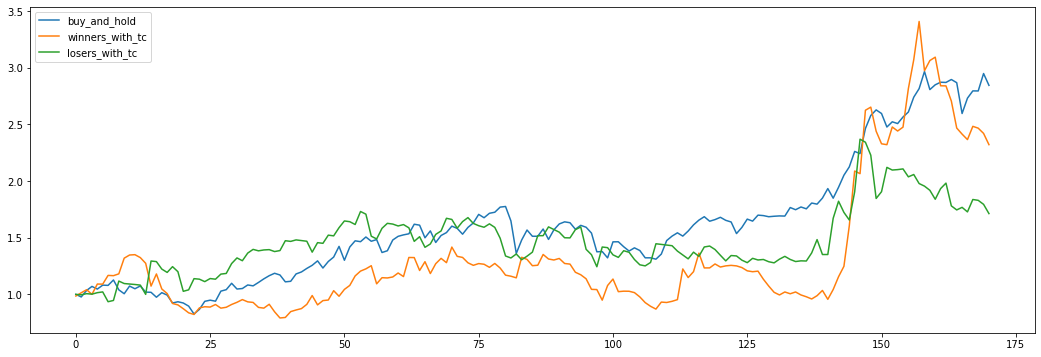

In [10]:
plt.figure(figsize=(18,6))
plt.plot(cumret_buyhold_20h[:-1], label='buy_and_hold')
plt.plot(cumret_winners[2:-2:2], label='winners_with_tc')
plt.plot(cumret_losers, label='losers_with_tc')
plt.legend()

# Shift forward by lookback period
## Market Momentum vs Reversion (periods from 30min to 24h)

In [11]:
columns = ['lookback_period', 'holding_period', 'correlation_coefficient', 'p_value']
results = pd.DataFrame(columns=columns)

for i_l,lookback in zip(index,periods): # lookback periods
    for i_h,hold in zip(index,periods): # holding periods
        if lookback>=hold:
            returns_lookback = df.iloc[::lookback].pct_change().dropna()
            start_index = returns_lookback.index[(returns_lookback.index + pd.Timedelta(i_h)) <= df.index[-1]]
            returns_lookback = returns_lookback.loc[start_index] # returns in lookback period
            prices_start = df.loc[start_index] # start of holding period
            prices_end = df.loc[start_index + pd.Timedelta(i_h)] # end of holding period
            returns_hold = prices_end.values/prices_start - 1 # returns in holding period
            corrcoef, pvalue = pearsonr(returns_lookback.sum(axis=1).values, returns_hold.sum(axis=1))
            results = results.append({'lookback_period':i_l, 'holding_period':i_h, 
                                      'correlation_coefficient':corrcoef, 'p_value':pvalue}, 
                                      ignore_index=True)

In [12]:
results.sort_values(by='correlation_coefficient')

,lookback_period,holding_period,correlation_coefficient,p_value
63,24h,16h,-0.242631,0.003503
57,24h,2h,-0.232889,0.004969
46,20h,1h,-0.202413,0.007569
62,24h,12h,-0.199596,0.016464
40,16h,6h,-0.192036,0.004620
...,...,...,...,...
51,20h,10h,0.033493,0.661775
52,20h,12h,0.049701,0.517328
0,30m,30m,0.051417,0.000018
47,20h,2h,0.127850,0.093680


## Top3 Winners/Losers Momentum vs Reversion (periods from 30min to 24h)

In [13]:
columns = ['lookback_period', 'holding_period', 'top_corrcoef', 'top_pvalue', 'bot_corrcoef', 'bot_pvalue']
results = pd.DataFrame(columns=columns)
topN = 3

for i_l,lookback in zip(index,periods): # lookback periods
    for i_h,hold in zip(index,periods): # holding periods
        if lookback>=hold:
            
            
            returns_lookback = df.iloc[::lookback].pct_change().dropna()
            start_index = returns_lookback.index[(returns_lookback.index + pd.Timedelta(i_h)) <= df.index[-1]]
            returns_lookback = returns_lookback.loc[start_index] # returns in lookback period
            prices_start = df.loc[start_index] # start of holding period
            prices_end = df.loc[start_index + pd.Timedelta(i_h)] # end of holding period
            returns_hold = prices_end/prices_start.values - 1 # returns in holding period
            returns_lookback.index = returns_hold.index # align indexes
            
            ret = pd.DataFrame(columns=['top_lp', 'top_hp', 'bot_lp', 'bot_hp'])
            for tm in returns_lookback.index:
                # check that top returns are positive and bottom are negative
                sorted_idx_neg = returns_lookback.loc[tm][returns_lookback.loc[tm]<0].sort_values().index
                sorted_idx_pos = returns_lookback.loc[tm][returns_lookback.loc[tm]>0].sort_values().index
                top_idx = sorted_idx_pos[-topN:]
                bot_idx = sorted_idx_neg[:topN]
                if len(top_idx)>0:
                    top_lp = returns_lookback.loc[tm,top_idx].sum()/len(top_idx)
                    top_hp = returns_hold.loc[tm,top_idx].sum()/len(top_idx)
                else:
                    top_lp = 0
                    top_hp = 0
                if len(bot_idx)>0:
                    bot_lp = returns_lookback.loc[tm,bot_idx].sum()/len(bot_idx)
                    bot_hp = returns_hold.loc[tm,bot_idx].sum()/len(bot_idx)
                else:
                    bot_lp = 0
                    bot_hp = 0

                ret = ret.append({'top_lp':top_lp, 'top_hp':top_hp, 'bot_lp':bot_lp, 'bot_hp':bot_hp}, 
                                         ignore_index=True)
            
            top_corrcoef, top_pvalue = pearsonr(ret['top_lp'].values, ret['top_hp'].values)
            bot_corrcoef, bot_pvalue = pearsonr(ret['bot_lp'].values, ret['bot_hp'].values)
            results = results.append({'lookback_period':i_l, 'holding_period':i_h, 
                                      'top_corrcoef':top_corrcoef, 'top_pvalue':top_pvalue, 
                                      'bot_corrcoef':bot_corrcoef, 'bot_pvalue':bot_pvalue}, 
                                      ignore_index=True)

In [14]:
results.sort_values(by='top_corrcoef')[results.columns[:-2]]

,lookback_period,holding_period,top_corrcoef,top_pvalue
21,10h,30m,-0.252694,1.862654e-06
45,20h,30m,-0.158070,3.779287e-02
46,20h,1h,-0.120246,1.150614e-01
60,24h,8h,-0.083156,3.217360e-01
4,2h,1h,-0.060330,1.198181e-02
...,...,...,...,...
19,8h,6h,0.326344,3.338366e-12
25,10h,6h,0.330717,2.830410e-10
38,16h,2h,0.347675,1.565826e-07
36,16h,30m,0.373087,1.540440e-08


In [15]:
results.sort_values(by='bot_corrcoef')[results.columns[[0,1,4,5]]]

,lookback_period,holding_period,bot_corrcoef,bot_pvalue
41,16h,8h,-0.285915,0.000020
63,24h,16h,-0.273762,0.000938
62,24h,12h,-0.260183,0.001636
42,16h,10h,-0.225768,0.000831
18,8h,4h,-0.220797,0.000004
...,...,...,...,...
24,10h,4h,-0.031937,0.553811
48,20h,4h,-0.030615,0.689270
26,10h,8h,-0.025070,0.642132
25,10h,6h,-0.006120,0.909699
